In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date, datetime, timezone
import os
import warnings

# import git
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import yaml
import esmlab
import esmlab_regrid

import config
import util

In [3]:
# input specifications

tracernames = [ 'NDEP_NOy_month', 'NDEP_NHx_month']

# IC specified by OMIP (macronutrients, O2, DIC, ALK)
ndep_in = os.path.join(os.sep, 'glade', 'p', 'cgd', 'oce', 'people', 'klindsay', 'oldcgdoce', 'BGC_2', 'ndep', 'src_files', 'fndep_clm_WACCM6_CMIP6piControl001_y21-50avg_1850monthly_0.95x1.25_c180802.nc')
print(f'Found {ndep_in}' if os.path.isfile(ndep_in) else f'MISSING {ndep_in}')

Found /glade/p/cgd/oce/people/klindsay/oldcgdoce/BGC_2/ndep/src_files/fndep_clm_WACCM6_CMIP6piControl001_y21-50avg_1850monthly_0.95x1.25_c180802.nc


In [4]:
# details on map to use
interp_method = 'conservative' # valid values include [conservative, bilinear, patch]
               
# details on file being generated
dst_grid = 'MOM_tx0.66v1'
ltripole = True
datestamp = date.today().strftime("%y%m%d")
fname_out = f'{config.dirout}/ndep_ocn_1850_w_nhx_emis_{dst_grid}_c{datestamp}.nc'
print(fname_out)

/glade/work/mlevy/cesm_inputdata/ndep_ocn_1850_w_nhx_emis_MOM_tx0.66v1_c210222.nc


In [5]:
# start ds_out as Dataset of grid variables
ds_in = xr.open_dataset(ndep_in, decode_times=False)
# ds_gustavo = xr.open_dataset("/glade/scratch/gmarques/bmom.e22.f09_t061_hycom1_N75.mct.baseline.004/run/INPUT/seawifs-clim-1997-2010-tx0.66v1.nc", decode_times=False)

# start ds_out as Dataset of grid variables
ds_out = xr.open_dataset('/glade/p/cesmdata/cseg/mapping/grids/tx0.66v1_SCRIP_190314.nc')
ni, nj = ds_out.grid_dims.data

# Set up coords
ds_out.coords['LON'] = ('LON'), ds_out['grid_center_lon'].values.reshape(nj, ni)[0,:]
ds_out.coords['LAT'] = ('LAT'), ds_out['grid_center_lat'].values.reshape(nj, ni)[:,142] # picking 142 because it contains ds_out['grid_center_lat'].max() [other columns do not reach highest latitudes]
ds_out.coords['TIME'] = ('TIME'), [15.5, 45, 74.5, 105, 135.5, 166, 196.5, 227.5, 258, 288.5, 319, 349.5] # ds_in['time'] % 365

# Set up atrtibutes on coords
ds_out.coords['LON'].attrs = ds_in['lon'].attrs
ds_out.coords['LON'].attrs['axis'] = 'X'
ds_out.coords['LAT'].attrs = ds_in['lat'].attrs
ds_out.coords['LAT'].attrs['axis'] = 'Y'
ds_out.coords['TIME'].attrs = ds_in['time'].attrs
ds_out.coords['TIME'].attrs['axis'] = 'T'
ds_out.coords['TIME'].attrs['cartesian_axis'] = 'T'
ds_out.coords['TIME'].attrs['modulo'] = ' '

print(f'ni = {ni}, nj = {nj}')
ds_out

ni = 540, nj = 458


<xarray.Dataset>
Dimensions:          (LAT: 458, LON: 540, TIME: 12, grid_corners: 4, grid_rank: 2, grid_size: 247320)
Coordinates:
  * LON              (LON) float64 -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * LAT              (LAT) float64 -79.2 -79.08 -78.95 ... 89.32 89.59 89.85
  * TIME             (TIME) float64 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
Dimensions without coordinates: grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 540 458
    grid_center_lat  (grid_size) float64 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    grid_center_lon  (grid_size) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    grid_imask       (grid_size) int32 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
    grid_area        (grid_size) float64 ...
Attributes:
    date_created:  Thu Mar 14 14:15:56 MDT 2019
    Createdby:     ESMF_regridding.ncl
    Conventions:   SCRIP
    title:         tx0.66v1 Grid

In [6]:
# Add MOM6 grid to regrid settings (super kludgy!)

with open('MOM_grid.yaml') as gridfile:
    MOM6_regrid = yaml.safe_load(gridfile)
regrid_settings = esmlab.config.get('regrid')
regrid_settings['grids']['MOM_tx0.66v1'] = MOM6_regrid
esmlab.config.set({'regrid' : regrid_settings});

USER = os.environ['USER']

In [7]:
if 'grid_dims' in ds_out.variables:
    ds_out = ds_out.drop(['grid_dims', 'grid_center_lat', 'grid_center_lon', 'grid_corner_lat', 'grid_corner_lon', 'grid_imask', 'grid_area'])
ds_out

<xarray.Dataset>
Dimensions:  (LAT: 458, LON: 540, TIME: 12)
Coordinates:
  * LON      (LON) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * LAT      (LAT) float64 -79.2 -79.08 -78.95 -78.82 ... 89.32 89.59 89.85
  * TIME     (TIME) float64 15.5 45.0 74.5 105.0 ... 258.0 288.5 319.0 349.5
Data variables:
    *empty*
Attributes:
    date_created:  Thu Mar 14 14:15:56 MDT 2019
    Createdby:     ESMF_regridding.ncl
    Conventions:   SCRIP
    title:         tx0.66v1 Grid

need to include NDEP_NOy_month from /glade/p/cgd/oce/people/klindsay/oldcgdoce/BGC_2/ndep/src_files/fndep_clm_WACCM6_CMIP6piControl001_y21-50avg_1850monthly_0.95x1.25_c180802.nc


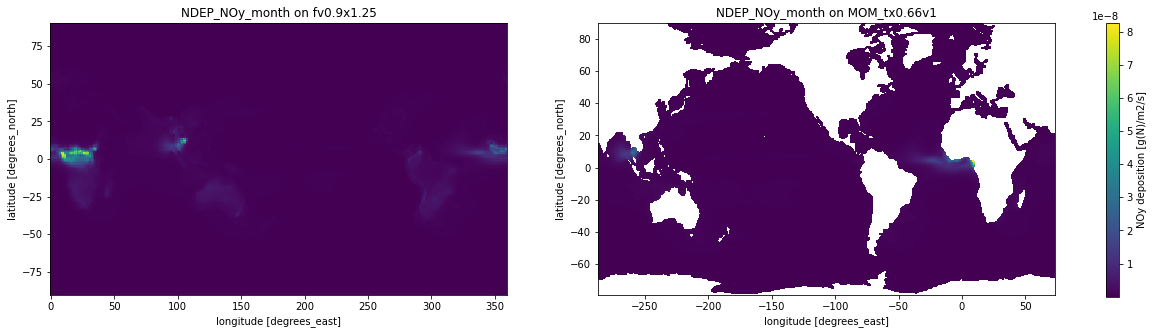


----

need to include NDEP_NHx_month from /glade/p/cgd/oce/people/klindsay/oldcgdoce/BGC_2/ndep/src_files/fndep_clm_WACCM6_CMIP6piControl001_y21-50avg_1850monthly_0.95x1.25_c180802.nc


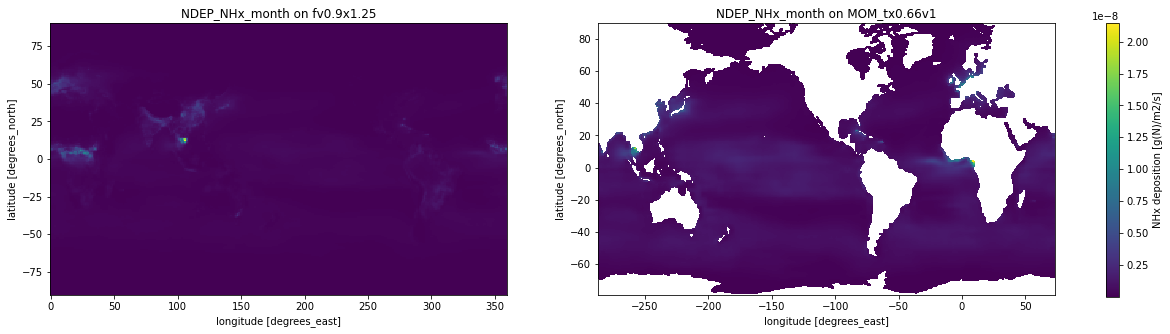


----

CPU times: user 1.06 s, sys: 207 ms, total: 1.27 s
Wall time: 1.43 s


In [8]:
%%time
# map tracers not yet in ds_out from refcase restart file to ds_out
src_grid = 'fv0.9x1.25' # note softlink in /glade/u/home/mlevy/.esmlab/esmlab-grid-files
fillvalue = -1.0e34 # value to replace land values with

for tracername in tracernames:
    if tracername not in ds_out.data_vars:
        print(f'need to include {tracername} from {ndep_in}')
        tracer=ds_in[tracername]

        # Plot on src grid
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18.0, 5.0))
        plt.subplot(121)
        tracer.isel(time=0).plot(add_colorbar=False)
        plt.title(f"{tracername} on {src_grid}")

        # perform lateral remapping
        regrid_operator = esmlab_regrid.regridder(
            name_grid_src=src_grid, name_grid_dst=dst_grid,
            method=interp_method, overwrite_existing=False)
        tracer_lateral_regrid = regrid_operator(tracer, renormalize=True)
        tracer_full_regrid = xr.DataArray(tracer_lateral_regrid, dims=('TIME', 'LAT', 'LON'),
                                          coords={'TIME':ds_out.TIME, 'LAT': ds_out.LAT, 'LON': ds_out.LON}, attrs=tracer.attrs)

        ds_out[tracername] = tracer_full_regrid
        ds_out[tracername].encoding["_FillValue"] = -1e34

        plt.subplot(122)
        my_plot = ds_out[tracername].isel(TIME=0).plot(add_colorbar=False)
        plt.title(f'{tracername} on {dst_grid}')
        cax = plt.axes((0.94, 0.12, 0.01, 0.76))
        cbar = fig.colorbar(my_plot, ax=axes.ravel().tolist(), cax=cax)
        cbar.set_label('{} [{}]'.format(tracer.attrs['long_name'],
                                        tracer.attrs['units']),
                                        rotation=90)
        plt.show()
        print('\n----\n')
        plt.show()

# print(ds_out)

In [9]:
nan_cnt = np.sum(np.isnan(ds_out['NDEP_NOy_month'].isel(TIME=0).values))
expected = np.sum(np.fromfile(MOM6_regrid['gen_grid_file']['kwargs']['topography_fname'], dtype='int32') == 0)
print(f'Found {nan_cnt} nans in first time level, expect {expected}; difference of {nan_cnt - expected}')

Found 95656 nans in first time level, expect 95656; difference of 0


In [10]:
# write generated file

datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_out.attrs['history'] = f'created by {USER} on {datestamp}'
# Note: we need time to be UNLIMITED due to an issue with how MOM reads data
util.ds_clean(ds_out).to_netcdf(fname_out, unlimited_dims='TIME')
print(f'created {fname_out}')

created /glade/work/mlevy/cesm_inputdata/ndep_ocn_1850_w_nhx_emis_MOM_tx0.66v1_c210222.nc
